<a href="https://colab.research.google.com/github/cicyfan/machine-learning-fundamentals/blob/master/7_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network from Scratch
Code modified from https://github.com/adventuresinML/adventures-in-ml-code/blob/master/neural_network_tutorial.py

The notation in this website is almost the same as the notation we are using in class.  Instead of $a$ the author uses $h$, and instead of $N$, the author uses $m$. (I have modified the code below to use $a$ and $N$.)

Please read about this implementation starting at page 27 from the website listed above.

## The first thing we will do is import all the libraries

We will be using the lower resolution MINST data set

In [0]:
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 

## Looking at the data

After we load the data, we print the shape of the data and a pixelated digit.

We also show what the features of one example looks like.

The neural net will learn to estimate which digit these pixels represent.

The shape of the digits dataset:
(1797, 64)


<Figure size 432x288 with 0 Axes>

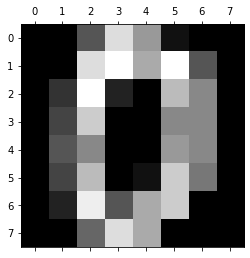

[0]
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [0]:
digits=load_digits()
X = digits.data
print("The shape of the digits dataset:") 
print(digits.data.shape)
plt.gray()
plt.matshow(digits.images[0])
plt.show()
y = digits.target
print(y[0:1])
print(X[0,:])

## 1) Scale the dataset
The training features range from 0 to 15.  To help the algorithm converge, we will scale the data to have a mean of 0 and unit variance

In [0]:
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)

X[0,:] # Looking the new features after scaling

array([ 0.        , -0.33501649, -0.04308102,  0.27407152, -0.66447751,
       -0.84412939, -0.40972392, -0.12502292, -0.05907756, -0.62400926,
        0.4829745 ,  0.75962245, -0.05842586,  1.12772113,  0.87958306,
       -0.13043338, -0.04462507,  0.11144272,  0.89588044, -0.86066632,
       -1.14964846,  0.51547187,  1.90596347, -0.11422184, -0.03337973,
        0.48648928,  0.46988512, -1.49990136, -1.61406277,  0.07639777,
        1.54181413, -0.04723238,  0.        ,  0.76465553,  0.05263019,
       -1.44763006, -1.73666443,  0.04361588,  1.43955804,  0.        ,
       -0.06134367,  0.8105536 ,  0.63011714, -1.12245711, -1.06623158,
        0.66096475,  0.81845076, -0.08874162, -0.03543326,  0.74211893,
        1.15065212, -0.86867056,  0.11012973,  0.53761116, -0.75743581,
       -0.20978513, -0.02359646, -0.29908135,  0.08671869,  0.20829258,
       -0.36677122, -1.14664746, -0.5056698 , -0.19600752])

## 2) Creating training and test datasets
We split the data into training and test data sets. We will train the neural network with the training dataset, and evaluate our neural network with the test dataset 

In [0]:
#Split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

## 3) Setting up the output layer

### One hot encoding
Our target is an integer in the range [0,..,9], so we will have 10 output neuron's in our network.  

-  If  $y=0$, we want the output neurons to have the values $(1,0,0,0,0,0,0,0,0,0)$

-  If  $y=1$ we want the output neurons to have the values $(0,1,0,0,0,0,0,0,0,0)$
-  etc

Thus we need to change our target so it is the same as our hoped for output of the neural network.  
-  If $y=0$ we change it into the vector $(1,0,0,0,0,0,0,0,0,0)$. 
-  If $y=1$ we change it into the vector $(0,1,0,0,0,0,0,0,0,0)$
-  etc

See page 29 from the website listed above

The code to covert the target vector.

In [0]:
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

Converting the training and test targets to vectors 

In [0]:
# convert digits to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

A quick check to see that our code performs as we expect 

In [0]:
print(y_train[0:4])
print(y_v_train[0:4])

[9 1 2 7]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


## 4) Creating the neural network

### The activation function and its derivative

We will use the sigmoid activation function:  $f(z)=\frac{1}{1+e^{-z}}$

The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 

In [0]:
def f(z):
    return 1 / (1 + np.exp(-z))

def f_deriv(z):
    return f(z) * (1 - f(z))

### Creating and initialing W and b
We want the weights in W to be different so that during back propagation the nodes on a level will have different gradients and thus have different update values.

We want the  weights to be small values, since the sigmoid is almost "flat" for large inputs.

Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  The code assumes that the number of neurons in each level is in the python list *nn_structure*.

In the code, the weights, $W^{(\ell)}$ and $b^{(\ell)}$ are held in a python dictionary

In [0]:
def default(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

### Initializing $\triangledown W$ and $\triangledown b$
Creating $\triangledown W^{(\ell)}$ and $\triangledown b^{(\ell)}$ to have the same size as $W^{(\ell)}$ and $b^{(\ell)}$, and setting $\triangledown W^{(\ell)}$, and  $\triangledown b^{(\ell)}$ to zero

In [0]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b



## Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [0]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

## Compute $\delta$
The code below compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  

If we wanted to have a different cost function, we would change the "calculate_out_layer_delta" function.


In [0]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

## The Back Propagation Algorithm


In [0]:
def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25, lamb=0.01, setup_and_init_weights=default):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('alpha:', alpha, 'lambda:', lamb, 'weight initialization:', setup_and_init_weights)
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            # W[l] += -alpha * (1.0/N * tri_W[l])
            # b[l] += -alpha * (1.0/N * tri_b[l])
            # add regularization
            W[l] += -alpha * (1.0/N * tri_W[l] + lamb/2 * W[l])
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

## Running the neural network

Our code assumes the size of each layer in our network is held in a list.  The input layer will have 64 neurons (one for each pixel in our 8 by 8 pixelated digit).  Our hidden layer has 30 neurons (you can change this value).  The output layer has 10 neurons.

Next we create the python list to hold the number of neurons for each level and then run the neural network code with our training data.

This code will take some time...

### Plotting the learning curve


In [0]:
def plot():
  # plot the avg_cost_func
  plt.plot(avg_cost_func)
  plt.ylabel('Average J')
  plt.xlabel('Iteration number')
  plt.show()

## 5) Assessing accuracy
Next we determine what percentage the neural network correctly predicted the handwritten digit correctly on the test set

In [0]:
def acc():
  # get the prediction accuracy and print
  y_pred = predict_y(W, b, X_test, 3)
  print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

In [0]:
nn_structure = [64, 30, 10]

alpha: 0.25 lambda: 0.01 weight initialization: <function default at 0x7f5081d441e0>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 4min 11s, sys: 31.4 ms, total: 4min 11s
Wall time: 4min 12s


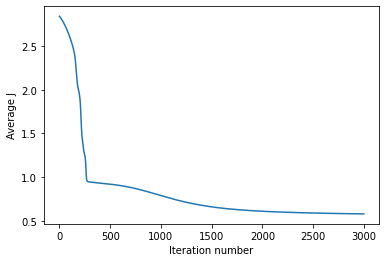

Prediction accuracy is 89.01251738525731%


In [0]:
# train the NN
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, 0.25, 0.01, default)

plot()
acc()

## 6) Parameter Tuning

### Weight Initialization Functions


#### Uniform

In [0]:
# Logistic
def logistic_uniform(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))*(np.sqrt(6/(nn_structure[l]+nn_structure[l-1])))
        b[l] = r.random_sample((nn_structure[l],))*(np.sqrt(6/(nn_structure[l]+nn_structure[l-1])))
    return W, b


# Hyperbolic tangent
def hyperbolic_tangent_uniform(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))*(4*np.sqrt(6/(nn_structure[l]+nn_structure[l-1])))
        b[l] = r.random_sample((nn_structure[l],))*(4*np.sqrt(6/(nn_structure[l]+nn_structure[l-1])))
    return W, b

# ReLU
def ReLU_uniform(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))*(np.sqrt(2)*np.sqrt(6/(nn_structure[l]+nn_structure[l-1])))
        b[l] = r.random_sample((nn_structure[l],))*(np.sqrt(2)*np.sqrt(6/(nn_structure[l]+nn_structure[l-1])))
    return W, b


#### Normal

In [0]:
# Logistic
def logistic_normal(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.normal(0, np.sqrt(2/(nn_structure[l]+nn_structure[l-1])), (nn_structure[l], nn_structure[l-1]))
        b[l] = r.normal(0, np.sqrt(2/(nn_structure[l]+nn_structure[l-1])), (nn_structure[l],))
    return W, b


# Hyperbolic tangent
def hyperbolic_normal(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = 4*r.normal(0, np.sqrt(2/(nn_structure[l]+nn_structure[l-1])), (nn_structure[l], nn_structure[l-1]))
        b[l] = 4*r.normal(0, np.sqrt(2/(nn_structure[l]+nn_structure[l-1])), (nn_structure[l],))
    return W, b

# ReLU
def ReLU_normal(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = np.sqrt(2)*r.normal(0, np.sqrt(2/(nn_structure[l]+nn_structure[l-1])), (nn_structure[l], nn_structure[l-1]))
        b[l] = np.sqrt(2)*r.normal(0, np.sqrt(2/(nn_structure[l]+nn_structure[l-1])), (nn_structure[l],))
    return W, b


### Sigmoid Activation


In [0]:
def f(z):
    return 1 / (1 + np.exp(-z))

def f_deriv(z):
    return f(z) * (1 - f(z))

def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

#### Default

alpha: 0.25 lambda: 0.01 weight initialization: <function default at 0x7f5081d441e0>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 4min 8s, sys: 26 ms, total: 4min 8s
Wall time: 4min 9s


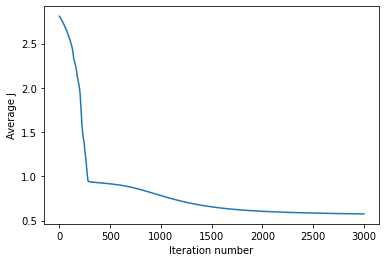

Prediction accuracy is 87.20445062586927%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)
plot()
acc()

alpha: 0.25 lambda: 0.01 weight initialization: <function default at 0x7f5081d441e0>
Starting gradient descent for 6000 iterations
Iteration 0 of 6000
Iteration 1000 of 6000
Iteration 2000 of 6000
Iteration 3000 of 6000
Iteration 4000 of 6000
Iteration 5000 of 6000
CPU times: user 8min 18s, sys: 83.9 ms, total: 8min 18s
Wall time: 8min 19s


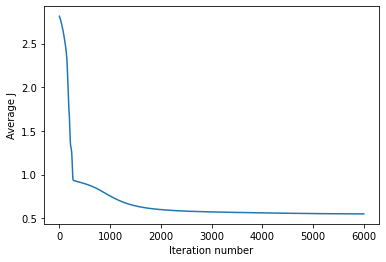

Prediction accuracy is 94.01947148817803%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 6000)
plot()
acc()

#### Uniform Distribution

alpha: 0.25 lambda: 0.01 weight initialization: <function logistic_uniform at 0x7f5081c919d8>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 4min 7s, sys: 36.8 ms, total: 4min 7s
Wall time: 4min 7s


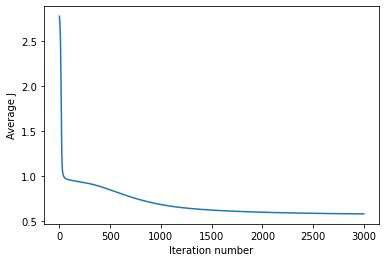

Prediction accuracy is 86.50904033379693%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, 0.25, 0.01, logistic_uniform)
plot()
acc()

#### Normal Distribution

alpha: 0.25 lambda: 0.01 weight initialization: <function logistic_normal at 0x7f5081c6e400>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 4min 9s, sys: 35.9 ms, total: 4min 9s
Wall time: 4min 9s


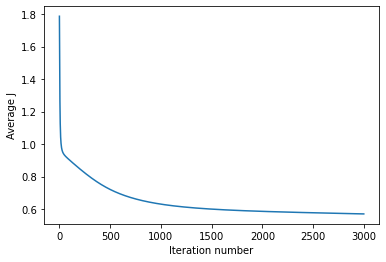

Prediction accuracy is 92.35048678720446%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, 0.25, 0.01, logistic_normal)
plot()
acc()

#### Lambda = 0.001

alpha: 0.25 lambda: 0.001 weight initialization: <function logistic_uniform at 0x7f5081c919d8>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 4min 13s, sys: 39.8 ms, total: 4min 13s
Wall time: 4min 13s


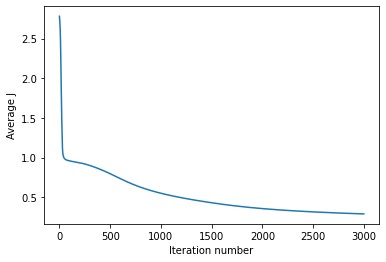

Prediction accuracy is 96.38386648122392%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, 0.25, 0.001, logistic_uniform)
plot()
acc()

### ReLU Activation

In [0]:
def f(z):
    return np.array([0 if x < 0 else x for x in z])

def f_deriv(z):
    return np.array([0 if x < 0 else 1 for x in z])

def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

#### Default

alpha: 0.25 lambda: 0.01 weight initialization: <function default at 0x7f5081d441e0>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 5min 22s, sys: 50 ms, total: 5min 22s
Wall time: 5min 23s


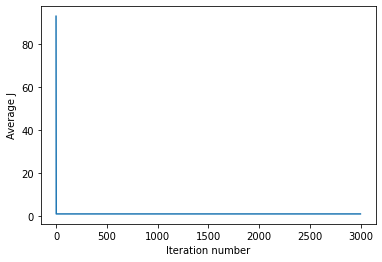

Prediction accuracy is 9.596662030598054%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)
plot()
acc()

alpha: 0.01 lambda: 0.01 weight initialization: <function default at 0x7f5081d441e0>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 5min 25s, sys: 55.8 ms, total: 5min 25s
Wall time: 5min 26s


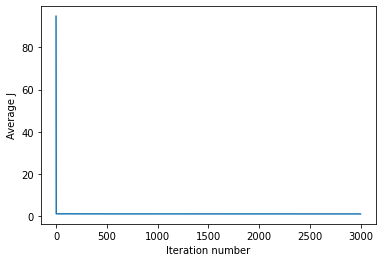

Prediction accuracy is 9.596662030598054%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, 0.01, 0.01)
plot()
acc()

#### Uniform Distribution

alpha: 0.25 lambda: 0.01 weight initialization: <function ReLU_uniform at 0x7f5081c91b70>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 5min 21s, sys: 61.7 ms, total: 5min 21s
Wall time: 5min 22s


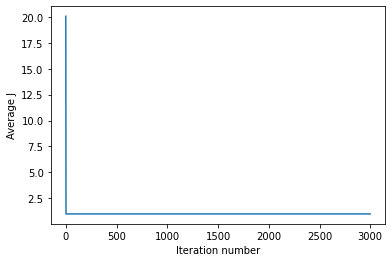

Prediction accuracy is 9.596662030598054%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, 0.25, 0.01, ReLU_uniform)
plot()
acc()

#### Normal

alpha: 0.25 lambda: 0.01 weight initialization: <function ReLU_normal at 0x7f5081c6e510>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 5min 27s, sys: 68.4 ms, total: 5min 27s
Wall time: 5min 27s


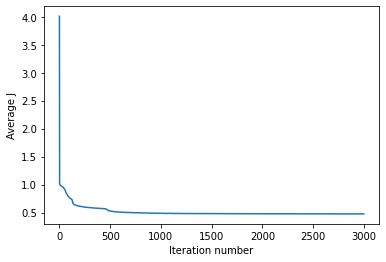

Prediction accuracy is 58.692628650904034%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, 0.25, 0.01, ReLU_normal)
plot()
acc()

#### Lambda = 0.001

alpha: 0.25 lambda: 0.001 weight initialization: <function ReLU_uniform at 0x7f5081c91b70>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 5min 24s, sys: 55.8 ms, total: 5min 24s
Wall time: 5min 25s


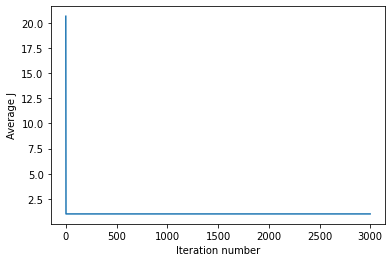

Prediction accuracy is 9.596662030598054%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, 0.25, 0.001, ReLU_uniform)
plot()
acc()

#### Leaky ReLu

alpha: 0.01 lambda: 0.01 weight initialization: <function ReLU_uniform at 0x7f5081c91b70>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 5min 23s, sys: 746 ms, total: 5min 23s
Wall time: 5min 24s


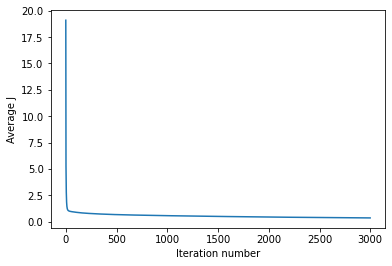

Prediction accuracy is 89.84700973574408%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, 0.01, 0.01, ReLU_uniform)
plot()
acc()

alpha: 0.01 lambda: 0.01 weight initialization: <function ReLU_uniform at 0x7f5081c91b70>
Starting gradient descent for 6000 iterations
Iteration 0 of 6000
Iteration 1000 of 6000
Iteration 2000 of 6000
Iteration 3000 of 6000
Iteration 4000 of 6000
Iteration 5000 of 6000
CPU times: user 10min 44s, sys: 776 ms, total: 10min 44s
Wall time: 10min 46s


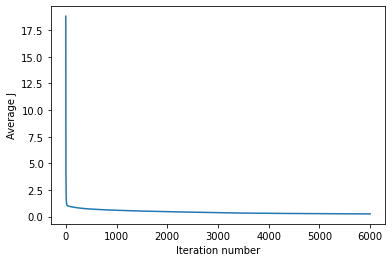

Prediction accuracy is 95.2712100139082%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 6000, 0.01, 0.01, ReLU_uniform)
plot()
acc()

### Tanh Activation

In [0]:
def f(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def f_deriv(z):
    return 1 - f(z)**2

def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

#### Default

alpha: 0.25 lambda: 0.01 weight initialization: <function default at 0x7f5081d441e0>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 4min 24s, sys: 52.9 ms, total: 4min 24s
Wall time: 4min 24s


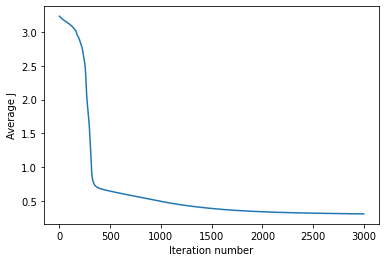

Prediction accuracy is 96.80111265646731%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)
plot()
acc()

#### Uniform Distribution

alpha: 0.25 lambda: 0.01 weight initialization: <function hyperbolic_tangent_uniform at 0x7f5081c91ae8>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 4min 25s, sys: 44.9 ms, total: 4min 25s
Wall time: 4min 25s


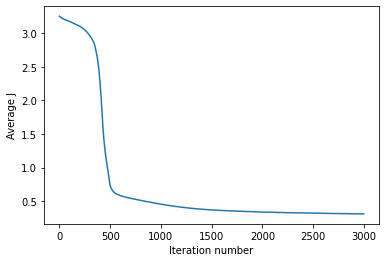

Prediction accuracy is 96.94019471488178%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, 0.25, 0.01, hyperbolic_tangent_uniform)
plot()
acc()

alpha: 0.25 lambda: 0.01 weight initialization: <function hyperbolic_tangent_uniform at 0x7f5081c91ae8>
Starting gradient descent for 6000 iterations
Iteration 0 of 6000
Iteration 1000 of 6000
Iteration 2000 of 6000
Iteration 3000 of 6000
Iteration 4000 of 6000
Iteration 5000 of 6000
CPU times: user 8min 52s, sys: 124 ms, total: 8min 52s
Wall time: 8min 53s


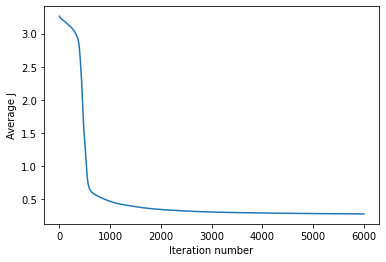

Prediction accuracy is 97.49652294853965%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 6000, 0.25, 0.01, hyperbolic_tangent_uniform)
plot()
acc()

#### Normal Distribution

alpha: 0.25 lambda: 0.01 weight initialization: <function hyperbolic_normal at 0x7f5081c6e488>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 4min 24s, sys: 44.8 ms, total: 4min 24s
Wall time: 4min 24s


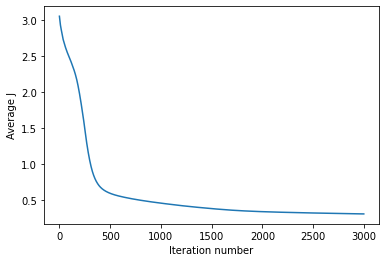

Prediction accuracy is 97.2183588317107%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, 0.25, 0.01, hyperbolic_normal)
plot()
acc()

#### Lambda = 0.001

alpha: 0.25 lambda: 0.001 weight initialization: <function hyperbolic_tangent_uniform at 0x7f5081c91ae8>
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000
CPU times: user 4min 25s, sys: 48.9 ms, total: 4min 25s
Wall time: 4min 25s


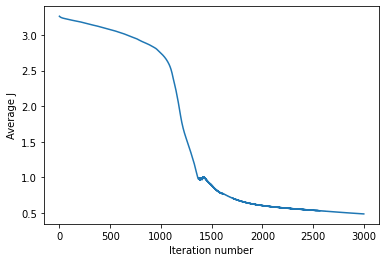

Prediction accuracy is 90.82058414464534%


In [0]:
%time W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000, 0.25, 0.001, hyperbolic_tangent_uniform)
plot()
acc()